## VQ-VAE
Introduced in the paper [Neural discrete representational learning](https://arxiv.org/pdf/1711.00937), VQ-VAE means vector quantisation variational autoencoder allows you to learn discrete latent codes from data. Language is inherently discrete [1](https://arxiv.org/pdf/1711.00937), similarly speech is typically represented as a sequence of symbols. Images can often be described concisely by language.


So the understanding is that we will have fixed codes to map from high dimension to low dimension. Lets take an image x and encode to $z_{e}$ using an encoder p(z/x). Now using L2 distance we will select the closest code $z_{q}$ to $z_{e}$. Now we will decode $z_{q}$ to get $x_{q}$ using decoder p(x/z).

$$
    x \overset{\text{encoder}}{\longrightarrow} z_{e} \overset{\text{quantisation}}{\longrightarrow} z_{q} \overset{\text{decoder}}{\longrightarrow} x_{q}
$$

so if u have a image of dimension 32x32x3, we can encode it to 512 dimension ($z_{e} \in \mathbb{R}^{512}$) and have $z_{q} \in \mathbb{R}^{1024}$ codes, with each code being 512, we will calculate L2 distance between $z_{e}$ and all the codes and select the one with the least distance, use this code to decode to $x_{q}$. Now the fundamental question i have is say if u have 50k images, how are we encoding them to just 1024 codes? and how can learn/reconstruct all the images from just 1024 codes? 

## Codebook size
Input Image: 32x32x3 (RGB image)
Encoded Representation: 4x4x512
Codebook Size: 1024 codes (each code is 512-dimensional)

The encoder produces 16 vectors (4x4=16) where each vector is 512-dimensional. Each of these 16 vectors gets mapped to its nearest neighbor in the codebook. This means:
- Each spatial location in the 4x4 encoded space selects one code from the codebook
- We need 16 selections from the codebook to represent one image
- Total possible combinations = 1024¹⁶ (or 2⁵¹²) unique images
- This massive space (2⁵¹²) easily accommodates our 50k training images

## Compression Analysis
VQ-VAE performs lossy compression. Here's why:

Original Image Size:
- Dimensions: 32x32x3 pixels
- Bits per pixel: 8 (0-255)
- Total bits: 32 × 32 × 3 × 8 = 24,576 bits

Compressed Representation:
- Need to store 16 indices (4x4 spatial locations)
- Each index needs 10 bits (to represent 1024 choices)
- Total bits: 16 × 10 = 160 bits

Compression ratio = 24,576/160 = 153.6x reduction in size


## How to learn the codebook?
The VQ_VAE paper using the following loss function to learn the codebook.

$$
    L = ||x - D[e(x)]||^2 + ||sg[e(x)] - C||^2 + \beta ||sg[C] - e(x)||^2
$$

where $D$ is the decoder, $e$ is the encoder, $C$ is the codebook, $sg$ is the stop gradient operation, $\beta$ is a scalar hyper parameter.
The first term is the reconstruction loss, the second term is the codebook loss and the third term is the commitment loss. The encoder and decoder are trained to minimise the reconstruction loss, while the codebook is updated to minimise the codebook loss and commitment loss. 


## Commitment loss
The commitment loss is used as a regularizer to ensure that both $z_{e}$ and $z_{q}$ are not changed simultaneously which makes training unstable. Lets take an example again.
- Iteration one - image1 has selected [10, 20] code book indices and $z_{e}$ is [0.1, 0.2]
- Iteration two - image1 has selected [30, 40] code book indices and $z_{e}$ is [0.15, 0.18]
so in the above case both $z_{e}$ and $z_{q}$ are changed simultaneously. To avoid this we use the commitment loss, where we keep the codebook fixed (hence the stop gradient operation so that it does not backpropagate and change the codebook) and try to push $z_{e}$ to be close to $z_{q}$. fixing the codebook makes more sense as ultimately code book learning useful features from the data is our main priority. 


Let's code this and see how it works.


## code 
- encoder encodes the image from say 32x32x3 to 4x4x512
- we define a latent embedding space KxD. where K is the size of discrete latent space and D is the dimensionality of each latent embedding vector.
- 

In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 
import torch 
import os 
import numpy as np
import torchvision
from tqdm import tqdm

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=False)

len(train_loader), len(val_loader)

(938, 157)

In [3]:
imgs, labels = next(iter(val_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

In [4]:
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            #32x32 -> 16x16
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #16x16 -> 8x8
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #8x8 -> 4x4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.encoder(x)
        return x 

In [5]:
enc = Encoder()
ze = enc(imgs)
ze.shape


torch.Size([64, 256, 4, 4])

In [6]:
## lets define a quantisation layer 

class VectorQuantisation(nn.Module):
    def __init__(self, e_dim=256, n_e=1024, beta=0.25):
        super().__init__()
        self.e_dim = e_dim
        self.beta = beta
        self.n_e = n_e 
        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)
    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        dist = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2 * torch.matmul(z_flattened, self.embedding.weight.t())
        
        min_encoding_indices = torch.argmin(dist, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(min_encoding_indices.shape[0], self.n_e).to(z)
        min_encodings.scatter_(1, min_encoding_indices, 1)
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        #calculate the loss
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)
        
        z_q = z + (z_q - z).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        return z_q, min_encoding_indices, loss

vq = VectorQuantisation()
z_q, min_encoding_indices, loss = vq(ze)
z_q.shape, min_encoding_indices.shape, loss

(torch.Size([64, 256, 4, 4]),
 torch.Size([1024, 1]),
 tensor(0.6118, grad_fn=<AddBackward0>))

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ReLU(),
            #4x4 -> 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #8x8 -> 16x16
            nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #32x32 -> 32x32            
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, z):
        z = self.decoder(z)
        return z


In [8]:
dec = Decoder()
x_out = dec(z_q)
x_out.shape

torch.Size([64, 1, 32, 32])

In [9]:
import torch.nn.functional as F
class VQVAE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.encoder = Encoder()
        self.vq = VectorQuantisation()
        self.decoder = Decoder()
        self.device = device

    def forward(self, x, loss_cal=True):
        ze = self.encoder(x)
        z_q, min_encoding_indices, loss = self.vq(ze)
        x_out = self.decoder(z_q)
        if loss_cal:
            reconstruction_loss = F.mse_loss(x_out, x)
            return x_out, min_encoding_indices, loss, reconstruction_loss
        else:
            return x_out, min_encoding_indices, loss

vqvae = VQVAE()

torch.Size([64, 1, 32, 32]) tensor(0.6273, device='mps:0', grad_fn=<AddBackward0>)


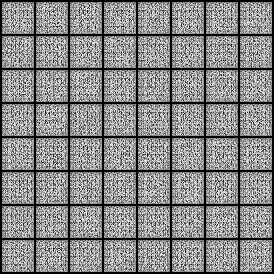

In [10]:
vae = VQVAE(device='mps')
vae.to(device='mps')

output, indices_selected, qloss = vae(imgs.to(device='mps'), loss_cal=False)
print(output.shape, qloss)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(output.view(64, 1, 32, 32).detach().cpu(), nrow=8))

In [11]:
indices_selected.view(64, 4, 4)[0]

tensor([[579, 579, 579, 579],
        [233, 306, 944, 455],
        [233, 425, 811,  20],
        [233, 640, 732, 497]], device='mps:0')

> so in a way we compressed the image from 32x32x3 to 4x4 indices. 

In [12]:
count = 0
for p in vae.parameters():
    count += p.numel()
count

1186273

In [13]:
epochs = 30
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-4)
total_iterations = epochs * len(train_loader)

iter = 0 
train_loss = []
val_loss = []
for epoch in range(epochs):
    vae.train()
    with tqdm(train_loader, total=len(train_loader), desc="Training", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device='mps')
            _, _, qloss, recon_loss = vae(x)
            loss = recon_loss + qloss
            #Add loss to the progress bar
            pbar.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), qloss=qloss.item())
            train_loss.append([loss.item(), recon_loss.item(), qloss.item()])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iter += 1
    
    vae.eval()
    with tqdm(val_loader, total=len(val_loader), desc="Validating", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device='mps')
            output, _, qloss, recon_loss = vae(x)
            loss = recon_loss + qloss
            val_loss.append([loss.item(), recon_loss.item(), qloss.item()])
            pbar.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), qloss=qloss.item())
            if i == 0:
                gen = output.detach().cpu()
    print(f'Epoch {epoch+1}/{epochs}, iter: {iter}, Train Loss: {np.mean(train_loss, axis=0)[0]:.4f}, Val Loss: {np.mean(val_loss, axis=0)[0]:.4f}, Train MSE: {np.mean(train_loss, axis=0)[1]:.4f}, Val MSE: {np.mean(val_loss, axis=0)[1]:.4f}, Train QLOSS: {np.mean(train_loss, axis=0)[2]:.4f}, Val QLOSS: {np.mean(val_loss, axis=0)[2]:.4f}')

    #Generate some images
    generated_imgs = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(gen, nrow=8))
    if not os.path.exists('generated'):
        os.makedirs('generated')
    generated_imgs.save(f'generated/vqvae_samples_{epoch+1}.png')



Epoch 1/30, iter: 938, Train Loss: 0.6583, Val Loss: 0.3942, Train MSE: 0.1081, Val MSE: 0.0642, Train QLOSS: 0.5502, Val QLOSS: 0.3301


Epoch 2/30, iter: 1876, Train Loss: 0.4610, Val Loss: 0.2855, Train MSE: 0.0822, Val MSE: 0.0561, Train QLOSS: 0.3788, Val QLOSS: 0.2294


Epoch 3/30, iter: 2814, Train Loss: 0.3524, Val Loss: 0.2251, Train MSE: 0.0694, Val MSE: 0.0506, Train QLOSS: 0.2830, Val QLOSS: 0.1745


Epoch 4/30, iter: 3752, Train Loss: 0.2867, Val Loss: 0.1896, Train MSE: 0.0609, Val MSE: 0.0459, Train QLOSS: 0.2258, Val QLOSS: 0.1437


Epoch 5/30, iter: 4690, Train Loss: 0.2443, Val Loss: 0.1652, Train MSE: 0.0545, Val MSE: 0.0419, Train QLOSS: 0.1898, Val QLOSS: 0.1233


Epoch 6/30, iter: 5628, Train Loss: 0.2138, Val Loss: 0.1470, Train MSE: 0.0496, Val MSE: 0.0389, Train QLOSS: 0.1642, Val QLOSS: 0.1081


Epoch 7/30, iter: 6566, Train Loss: 0.1906, Val Loss: 0.1329, Train MSE: 0.0458, Val MSE: 0.0364, Train QLOSS: 0.1449, Val QLOSS: 0.0965


Epoch 8/30, iter: 7504, Train Loss: 0.1726, Val Loss: 0.1219, Train MSE: 0.0427, Val MSE: 0.0344, Train QLOSS: 0.1299, Val QLOSS: 0.0875


Epoch 9/30, iter: 8442, Train Loss: 0.1583, Val Loss: 0.1131, Train MSE: 0.0402, Val MSE: 0.0328, Train QLOSS: 0.1181, Val QLOSS: 0.0803


Epoch 10/30, iter: 9380, Train Loss: 0.1467, Val Loss: 0.1058, Train MSE: 0.0381, Val MSE: 0.0314, Train QLOSS: 0.1085, Val QLOSS: 0.0744


Epoch 11/30, iter: 10318, Train Loss: 0.1368, Val Loss: 0.0995, Train MSE: 0.0363, Val MSE: 0.0302, Train QLOSS: 0.1005, Val QLOSS: 0.0693


Epoch 12/30, iter: 11256, Train Loss: 0.1284, Val Loss: 0.0940, Train MSE: 0.0348, Val MSE: 0.0291, Train QLOSS: 0.0936, Val QLOSS: 0.0650


Epoch 13/30, iter: 12194, Train Loss: 0.1211, Val Loss: 0.0893, Train MSE: 0.0334, Val MSE: 0.0281, Train QLOSS: 0.0877, Val QLOSS: 0.0612


Epoch 14/30, iter: 13132, Train Loss: 0.1148, Val Loss: 0.0852, Train MSE: 0.0322, Val MSE: 0.0273, Train QLOSS: 0.0826, Val QLOSS: 0.0579


Epoch 15/30, iter: 14070, Train Loss: 0.1093, Val Loss: 0.0815, Train MSE: 0.0312, Val MSE: 0.0265, Train QLOSS: 0.0781, Val QLOSS: 0.0550


Epoch 16/30, iter: 15008, Train Loss: 0.1044, Val Loss: 0.0783, Train MSE: 0.0302, Val MSE: 0.0258, Train QLOSS: 0.0741, Val QLOSS: 0.0525


Epoch 17/30, iter: 15946, Train Loss: 0.1000, Val Loss: 0.0753, Train MSE: 0.0294, Val MSE: 0.0252, Train QLOSS: 0.0706, Val QLOSS: 0.0502


Epoch 18/30, iter: 16884, Train Loss: 0.0960, Val Loss: 0.0727, Train MSE: 0.0286, Val MSE: 0.0246, Train QLOSS: 0.0675, Val QLOSS: 0.0481


Epoch 19/30, iter: 17822, Train Loss: 0.0925, Val Loss: 0.0703, Train MSE: 0.0278, Val MSE: 0.0241, Train QLOSS: 0.0646, Val QLOSS: 0.0462


Epoch 20/30, iter: 18760, Train Loss: 0.0892, Val Loss: 0.0681, Train MSE: 0.0272, Val MSE: 0.0236, Train QLOSS: 0.0620, Val QLOSS: 0.0445


Epoch 21/30, iter: 19698, Train Loss: 0.0862, Val Loss: 0.0661, Train MSE: 0.0266, Val MSE: 0.0231, Train QLOSS: 0.0597, Val QLOSS: 0.0430


Epoch 22/30, iter: 20636, Train Loss: 0.0835, Val Loss: 0.0643, Train MSE: 0.0260, Val MSE: 0.0227, Train QLOSS: 0.0575, Val QLOSS: 0.0416


Epoch 23/30, iter: 21574, Train Loss: 0.0810, Val Loss: 0.0626, Train MSE: 0.0255, Val MSE: 0.0223, Train QLOSS: 0.0555, Val QLOSS: 0.0403


Epoch 24/30, iter: 22512, Train Loss: 0.0787, Val Loss: 0.0610, Train MSE: 0.0250, Val MSE: 0.0219, Train QLOSS: 0.0537, Val QLOSS: 0.0391


Epoch 25/30, iter: 23450, Train Loss: 0.0766, Val Loss: 0.0595, Train MSE: 0.0245, Val MSE: 0.0216, Train QLOSS: 0.0521, Val QLOSS: 0.0380


Epoch 26/30, iter: 24388, Train Loss: 0.0746, Val Loss: 0.0582, Train MSE: 0.0241, Val MSE: 0.0212, Train QLOSS: 0.0505, Val QLOSS: 0.0369


Epoch 27/30, iter: 25326, Train Loss: 0.0727, Val Loss: 0.0569, Train MSE: 0.0237, Val MSE: 0.0209, Train QLOSS: 0.0491, Val QLOSS: 0.0360


Epoch 28/30, iter: 26264, Train Loss: 0.0710, Val Loss: 0.0557, Train MSE: 0.0233, Val MSE: 0.0206, Train QLOSS: 0.0477, Val QLOSS: 0.0351


Epoch 29/30, iter: 27202, Train Loss: 0.0694, Val Loss: 0.0546, Train MSE: 0.0229, Val MSE: 0.0204, Train QLOSS: 0.0464, Val QLOSS: 0.0342


Epoch 30/30, iter: 28140, Train Loss: 0.0679, Val Loss: 0.0535, Train MSE: 0.0226, Val MSE: 0.0201, Train QLOSS: 0.0453, Val QLOSS: 0.0334


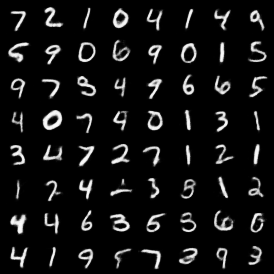

In [15]:
generated_imgs

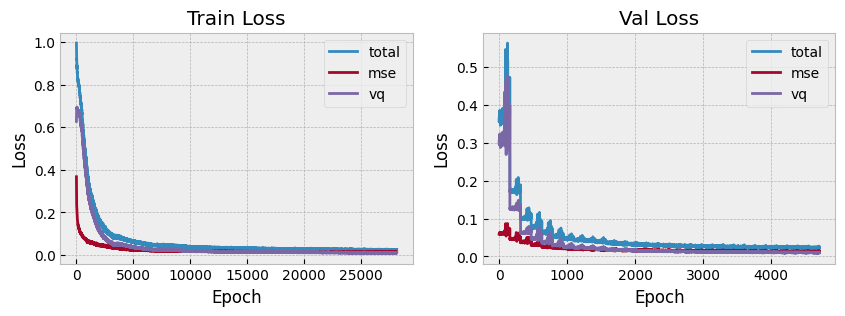

In [14]:
## visualize the losses 
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax.flat[0].plot(train_loss)
ax.flat[1].plot(val_loss)
ax.flat[0].legend(["total", "mse", "vq"])
ax.flat[1].legend(["total", "mse", "vq"])
ax.flat[0].set_title('Train Loss')
ax.flat[1].set_title('Val Loss')
ax.flat[0].set_xlabel('Epoch')
ax.flat[1].set_xlabel('Epoch')
ax.flat[0].set_ylabel('Loss')
ax.flat[1].set_ylabel('Loss')
plt.show()


> VQ-VAE is a powerful model for compressing images. It is a type of autoencoder that uses a codebook to compress the latent space. The codebook is a set of vectors that are used to represent the latent space. The codebook is learned during the training process. The codebook is used to decode the latent space back to the original image.


> VQ-VAE is not generative we can use the discrete latents to train a autoregressive model to make it generative. 


In the first iteration we used 512 codes x 128 dim size vector and 1e-3 lr. this experiement failed. In second we are using 1024x256 code book and 1e-4 lr, the reconstruction looks okay.

## TODO:
- Add pixelcnn and its inference 
- calculate bits/dim and explain its theory
- we need to see how much of the codebook is used. Perpexility is the metric used to implement it. we will check what it does. 


# Resources 
- [VQ layer copied from](https://github.com/CompVis/taming-transformers/blob/master/taming/modules/vqvae/quantize.py) 